# Preparing preprocessed data for analysis
In this notebook we will prepare the preprocessed data for analysis by creating epochs. 

## Setting up Python
First of all, we need to make sure that we are working in the `env` environment.


1. Run `bash env_to_jupyter.sh` from the `EEG` folder if you have not already done so. This will make sure that the `env` environment is available as a kernel in this notebook.

2. Press `Select Kernel`, then `Jupyter kernel...` and select `env`. If `env` does not show up, press the little refresh symbol!

**Note:** You might have to install the Jupyter extension for VScode to be able to select the kernel.

In [1]:
import mne
import os

## Load the preprocessed data

In [2]:
input_path = os.path.join(os.getcwd(), 'data_own_exp')
filename = "preprocessed_data_1.fif"

raw = mne.io.read_raw_fif(os.path.join(input_path, filename), preload=True)

Opening raw data file /work/SofiaScharf-Matthiesen#5940/EEG_Own_Analysis/data_own_exp/preprocessed_data_1.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 28) active
    Range : 0 ... 945759 =      0.000 ...   945.759 secs
Ready.
Reading 0 ... 945759  =      0.000 ...   945.759 secs...


/tmp/ipykernel_10823/1805707161.py:4: RuntimeWarning: This filename (/work/SofiaScharf-Matthiesen#5940/EEG_Own_Analysis/data_own_exp/preprocessed_data_1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(os.path.join(input_path, filename), preload=True)


## Epoching of EEG data
Now that the data has been preprocessed, we can epoch the data. Epoching is the process of cutting the continuous data into smaller segments, called epochs. Each epoch is a time window of the data, centered around an event of interest.

In MNE toolkit, the `Epochs` class is used to represent data that has been segmented into epochs, and it provides methods for averaging, baseline correction, plotting, and so forth.

For a great overall introduction see MNE's [epoch overview](https://mne.tools/stable/auto_tutorials/epochs/10_epochs_overview.html).

**To begin with we need to locate the events. This can be done using the find_events() function.**

In [3]:
import numpy as np
events = mne.events_from_annotations(raw)

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 15'), np.str_('Stimulus/S 98'), np.str_('Stimulus/S 99'), np.str_('Stimulus/S200'), np.str_('Stimulus/S201'), np.str_('Stimulus/S202'), np.str_('Stimulus/S203'), np.str_('Stimulus/S204'), np.str_('Stimulus/S210'), np.str_('Stimulus/S218'), np.str_('Stimulus/S219')]


In [4]:
events = events[0]
events[:, -1]
trigger_names = np.unique(events[:, -1])
trigger_names

array([    1,     4,     5,    10,    11,    15,    98,    99,   200,
         201,   202,   203,   204,   210,   218,   219, 99999])

**Create a dictionary of what each event ID represents.**

I have already done this for you, but you can also do it yourself by looking at the events in the raw data and the documentation of the sample data.

By using '/' we can actually later index one dimension *across* the other, i.e. if we just write 'auditory' we get all auditory events, both to the left and right ear. If we write 'auditory/left' we get only the events presented to the left ear.

In [5]:
# defining the events
event_id = {
    'Experiment/Start ': 1,
    #'Baseline/End' : 2, 
    #'Experiment/End': 3,
    'Question/Shows': 4, 
    #'Correct': 40,
    #'Incorrect':41
    'Question/Disappears': 5, 
    'Disappears': 10, 
    'Disappears/NearCorner': 11, 
    'Normal/Reappears': 200, 
    'Normal/Reappears/NearCorner': 201,
    'Surprise/Reappears': 210,
    #'Reappears/Sup/NearCorner': 211,
    'FinalDisappear': 98,
    'CornerHit': 99, 
}

**Visualise the events by using the mne.viz.plot_events() function**

/tmp/ipykernel_10823/3571025446.py:1: RuntimeWarning: event 15 missing from event_id will be ignored
  mne.viz.plot_events(
/tmp/ipykernel_10823/3571025446.py:1: RuntimeWarning: event 202 missing from event_id will be ignored
  mne.viz.plot_events(
/tmp/ipykernel_10823/3571025446.py:1: RuntimeWarning: event 203 missing from event_id will be ignored
  mne.viz.plot_events(
/tmp/ipykernel_10823/3571025446.py:1: RuntimeWarning: event 204 missing from event_id will be ignored
  mne.viz.plot_events(
/tmp/ipykernel_10823/3571025446.py:1: RuntimeWarning: event 218 missing from event_id will be ignored
  mne.viz.plot_events(
/tmp/ipykernel_10823/3571025446.py:1: RuntimeWarning: event 219 missing from event_id will be ignored
  mne.viz.plot_events(
/tmp/ipykernel_10823/3571025446.py:1: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(
/tmp/ipykernel_10823/3571025446.py:1: RuntimeWarning: More events than default colors available. You should pass a list of u

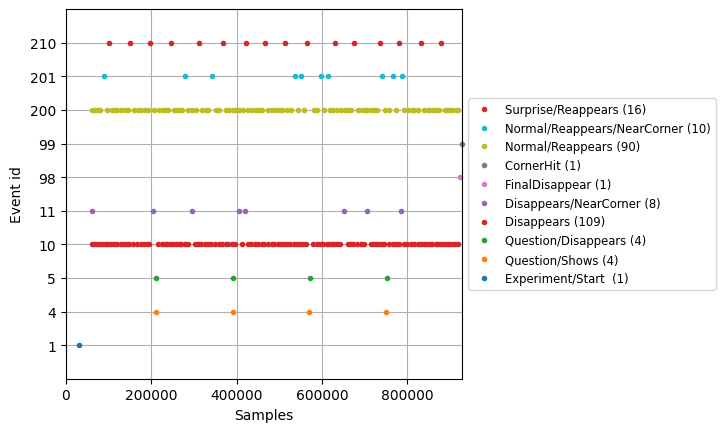

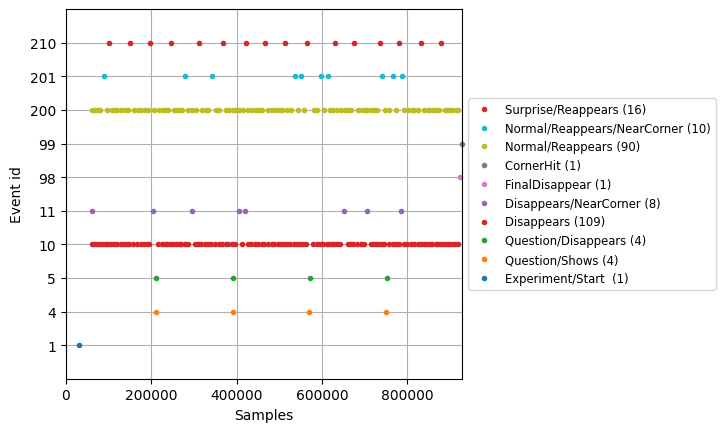

In [6]:
mne.viz.plot_events(
    events, event_id=event_id
)

**Establish a time window for the epochs.**

One suggestion is to use a time window of 200 ms before the stimulus onset to 500 ms after the stimulus onset. 
The 200 milliseconds before the onset of the stimulus enables us to examine a baseline of activity without stimulus presentation. The 500 milliseconds after the stimulus onset denote the time in which we expect the effect to occur. 

In [7]:
tmin, tmax = -0.2, 0.5

**Establish a threshold for rejecting epochs.**
There are many ways to detect and deal with artefacts. Today, we simply select a value and reject anything above or below that value. We do this because we determine that values over or under this threshold are liekly not related to brain activity. 

There are additonal ways to deal with artefacts, such as ICA (presented as an optional exercise in the `EEG_preprocessing` notebook).

In [8]:
# rejecting everything over or under a threshold of 150 microvolts
# anything above or belove this threshold is likely not brain activity but artefacts
# this is not doing anything yet, we just specify the threshold for later!

# extra note: using a dictionary as it allows to specify different thresholds for different channels, for example if both EEG and MEG is recorded (however we only have one channel type here)
reject = {'eeg': 150e-6}

**Create a `picks` variable with only EEG channels**

In [9]:
picks = ['eeg']

**Create the epochs by using the mne.Epochs class**
* Use the `reject` argument to reject epochs that are above or below the threshold we set earlier
* Use the `tmin` and `tmax` arguments to set the time window for the epochs
* Use the `baseline` argument to set the baseline for the epochs (from -0.2 seconds to 0 seconds relative to the event onset) 

*Hint: See this [link](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs) on the `Epochs` class*

In [10]:
epochs = mne.Epochs(raw, events=events, event_id=event_id, reject=reject, tmin=tmin, tmax=tmax, baseline=(-0.2, 0.0), preload=True)

Not setting metadata
244 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 244 events and 701 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['F7', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
12 bad epochs dropped


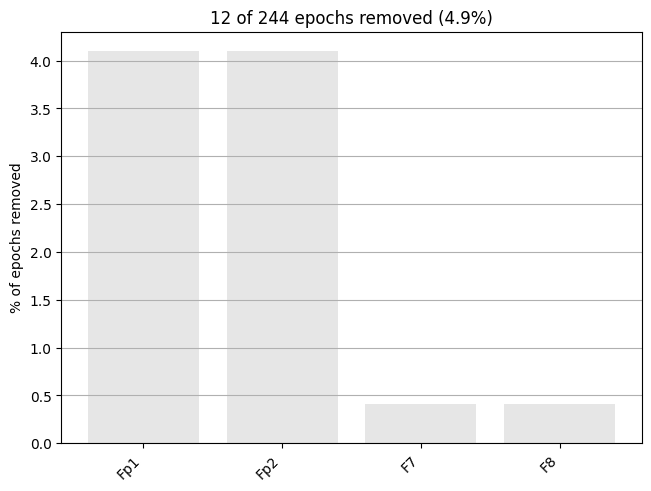

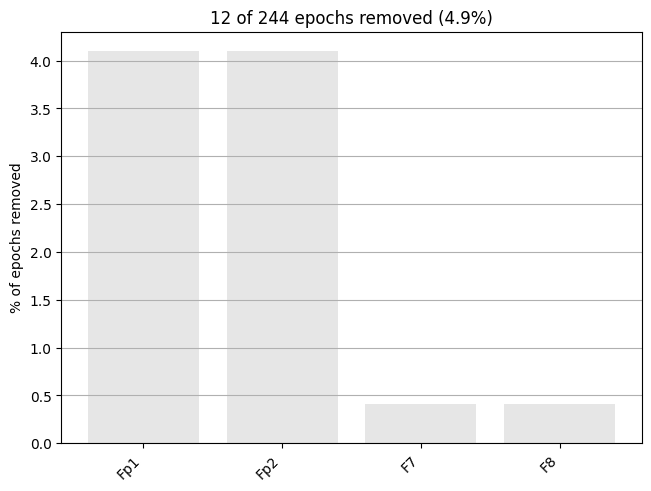

In [11]:
epochs.plot_drop_log()

## Downsample the data
To reduce the amount of data we have to work with as well as the amount of time it takes to run the analysis the data is downsampled. This is done after epoching, as doing it before epoching can potentially mess with the precision of the extraction of epochs.

*Hint: go to this [link](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.resample)*

**Resample the data to 250 Hz**

In [12]:
events = epochs.resample(sfreq=250)

## Save the epochs
We will save the epochs as a `.fif` file. This is a file format that is specific to MNE. It is a binary file format that is very fast to read and write. It also stores all the metadata that we need to keep track of the data.

In [13]:
outpath = os.path.join(os.getcwd(), 'epochs')

if not os.path.exists(outpath):
    os.makedirs(outpath)

epochs.save(os.path.join(outpath, 'epochs-epo_1.fif'), overwrite=True)

Overwriting existing file.
Overwriting existing file.


/tmp/ipykernel_10823/2959401253.py:6: RuntimeWarning: This filename (/work/SofiaScharf-Matthiesen#5940/EEG_Own_Analysis/epochs/epochs-epo_1.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(os.path.join(outpath, 'epochs-epo_1.fif'), overwrite=True)
